In [142]:
# Load all library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

### Data loading

In [143]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# load all datasets as dataframe
data1 = pd.read_csv(r'D:\AIS_project\Udemy.csv')
data2 = pd.read_csv(r'D:\AIS_project\skillshare.csv')
data3 = pd.read_csv(r'D:\AIS_project\edx.csv')
data4 = pd.read_csv(r'D:\AIS_project\Coursera.csv')
# data1 = pd.read_csv('/Users/zhiyuwang/Documents/courses/AIS/AIS_project/Zhiyu/Data/Udemy.csv')
# data2 = pd.read_csv('/Users/zhiyuwang/Documents/courses/AIS/AIS_project/Zhiyu/Data/skillshare.csv')
# data3 = pd.read_csv('/Users/zhiyuwang/Documents/courses/AIS/AIS_project/Zhiyu/Data/edx.csv')
# data4 = pd.read_csv('/Users/zhiyuwang/Documents/courses/AIS/AIS_project/Zhiyu/Data/Coursera.csv')
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)
df4 = pd.DataFrame(data4)


In [144]:
print(f'df1:{df1.head()}')
# print(f'df2:{df2.head()}')
# print(f'df3:{df3.head()}')
# print(f'df4:{df4.head()}')

df1:                                               title  \
0  The Complete Python Bootcamp From Zero to Hero...   
1         The Complete 2023 Web Development Bootcamp   
2                    The Web Developer Bootcamp 2023   
3  100 Days of Code: The Complete Python Pro Boot...   
4  React - The Complete Guide 2023 (incl. React R...   

                                         description  \
0  Learn Python like a Professional  Start from t...   
1  Become a Full-Stack Web Developer with just ON...   
2  10 Hours of React just added. Become a Develop...   
3  Master Python by building 100 projects in 100 ...   
4  Dive in and learn React.js from scratch! Learn...   

                                          instructor  rating  reviewcount  \
0                                      Jose Portilla     4.6       486391   
1                                      Dr. Angela Yu     4.7       338555   
2                                        Colt Steele     4.7       266527   
3             

In [145]:
print(f'df1:{df1.shape}')
# print(f'df2:{df2.shape}')
# print(f'df3:{df3.shape}')
# print(f'df4:{df4.shape}')

df1:(26256, 8)


In [146]:
print(f'df1:{df1.columns}')
# print(f'df2:{df2.columns}')
# print(f'df3:{df3.columns}')
# print(f'df4:{df4.columns}')

df1:Index(['title', 'description', 'instructor', 'rating', 'reviewcount',
       'duration', 'lectures', 'level'],
      dtype='object')


# Data processing for __Basic recommendation system__
__only use title, language, level, crediteligibility as features for basic clustering__

In [147]:
#add sythetic language column
columns_to_concat = ['title','level']
df_basic= pd.concat([df1[col] for col in columns_to_concat], axis=1)

languages = ['English', 'Spanish', 'French', 'German', 'Chinese']
crediteligibility = ['Yes', 'No']
df_basic['language'] = np.random.choice(languages, size=len(df_basic))
df_basic['crediteligibility'] = np.random.choice(crediteligibility , size=len(df_basic))
df_basic

,title,level,language,crediteligibility
0,The Complete Python Bootcamp From Zero to Hero...,All Levels,English,No
1,The Complete 2023 Web Development Bootcamp,All Levels,German,No
2,The Web Developer Bootcamp 2023,All Levels,French,Yes
3,100 Days of Code: The Complete Python Pro Boot...,All Levels,French,Yes
4,React - The Complete Guide 2023 (incl. React R...,All Levels,English,Yes
...,...,...,...,...
26251,Business English for Meetings,Intermediate,Chinese,No
26252,Aerospace Engineering: Aircraft Systems and Av...,All Levels,French,Yes
26253,Forensic Psychology : Criminal Profiling Certi...,Beginner,English,Yes
26254,Deutsch Intensiv - Intensive German Course for...,Beginner,French,Yes


In [148]:
df_basic.isna().any()

title                False
level                 True
language             False
crediteligibility    False
dtype: bool

In [149]:
# full the NaN data in Level column 
non_nan_values = df_basic['level'].dropna()
# Randomly sample from the non-NaN values to fill NaNs
df_basic['level'] = df_basic['level'].apply(lambda x: np.random.choice(non_nan_values) if pd.isna(x) else x)
df_basic.isna().any()

title                False
level                False
language             False
crediteligibility    False
dtype: bool

In [150]:
#get the count of unique element in columns
for column in df_basic.columns[1:]:
    print(f"Unique elements in column '{column}':")
    print(df_basic[column].value_counts())
    print("\n")

Unique elements in column 'level':
level
All Levels      14999
Beginner         7573
Intermediate     3232
Expert            452
Name: count, dtype: int64


Unique elements in column 'language':
language
Spanish    5308
Chinese    5304
German     5297
English    5241
French     5106
Name: count, dtype: int64


Unique elements in column 'crediteligibility':
crediteligibility
Yes    13139
No     13117
Name: count, dtype: int64




### Synthetic Data augmentation for 'level' colum

In [151]:
import pandas as pd
import numpy as np

# Target for each level (calculating average target count)
total_entries = len(df_basic)
num_levels = 4  # Levels: 'All Levels', 'Beginner', 'Intermediate', 'Expert'
target_count = total_entries // num_levels

# Current counts
current_counts = df_basic['level'].value_counts()

# Target count for each level
level_counts = {
    'Beginner': target_count,
    'Intermediate': target_count,
    'Expert': target_count,
}

# Calculate how much each level is under or over the target
all_levels_count = current_counts.get('All Levels', 0)
beginner_count = current_counts.get('Beginner', 0)
intermediate_count = current_counts.get('Intermediate', 0)
expert_count = current_counts.get('Expert', 0)

# Calculate how many 'All Levels' need to be redistributed
needed_for_others = (
    (level_counts['Beginner'] - beginner_count) +
    (level_counts['Intermediate'] - intermediate_count) +
    (level_counts['Expert'] - expert_count)
)

# Make sure the 'All Levels' count is enough to redistribute
if all_levels_count >= needed_for_others:
    # Randomly select rows from 'All Levels' to redistribute
    np.random.seed(42)  # For reproducibility
    all_levels_mask = df_basic['level'] == 'All Levels'
    
    # Levels to distribute to
    levels = ['Beginner', 'Intermediate', 'Expert']
    
    # Redistribute to each level
    for level in levels:
        # Calculate how many entries we need to move
        current_level_count = df_basic[df_basic['level'] == level].shape[0]
        target_for_level = level_counts[level]
        needed_for_level = target_for_level - current_level_count
        
        if needed_for_level > 0:
            # Randomly select rows from 'All Levels' and assign to this level
            idx_to_replace = df_basic[all_levels_mask].sample(n=needed_for_level, random_state=42).index
            df_basic.loc[idx_to_replace, 'level'] = level
            
            # Update the all_levels_mask to remove the rows that have been reassigned
            all_levels_mask = df_basic['level'] == 'All Levels'

# Check the distribution after replacement
print(df_basic['level'].value_counts())


level
Beginner        7573
Expert          6564
Intermediate    6564
All Levels      5555
Name: count, dtype: int64


In [152]:
# To reduce the clustering runtime for the showcase, I will randomly select 5000 datapoint the dataset after processing.
df_sampled = df_basic.sample(n=10000, random_state=42)

# Display the sampled DataFrame
print(df_sampled)

                                                   title         level  \
19789  AWS Cloud Development Kit - From Beginner to P...  Intermediate   
20090    Cisco CCNP Route (300-101): The Complete Course  Intermediate   
8049   Build Windows Forms App with Visual Studio - L...    All Levels   
6011   Integration & Resilient Design Patterns with S...  Intermediate   
22176  Excel: Core Data Analysis, and Workbook Custom...        Expert   
...                                                  ...           ...   
18232      Hidden Passive Income: Staking Cryptocurrency      Beginner   
13366                      ISO 9001 2015 Risk Management        Expert   
13090  How to buy Real Estate Subject to the existing...  Intermediate   
5360      Build REST API using Python, Flask and Postman        Expert   
22231                 Completely Master Google Classroom        Expert   

      language crediteligibility  
19789  Spanish                No  
20090  Chinese               Yes  
8049  

In [153]:
df_sampled.to_csv('input.csv')
df_sampled

,title,level,language,crediteligibility
19789,AWS Cloud Development Kit - From Beginner to P...,Intermediate,Spanish,No
20090,Cisco CCNP Route (300-101): The Complete Course,Intermediate,Chinese,Yes
8049,Build Windows Forms App with Visual Studio - L...,All Levels,English,Yes
6011,Integration & Resilient Design Patterns with S...,Intermediate,French,Yes
22176,"Excel: Core Data Analysis, and Workbook Custom...",Expert,German,No
...,...,...,...,...
18232,Hidden Passive Income: Staking Cryptocurrency,Beginner,English,Yes
13366,ISO 9001 2015 Risk Management,Expert,English,No
13090,How to buy Real Estate Subject to the existing...,Intermediate,Chinese,Yes
5360,"Build REST API using Python, Flask and Postman",Expert,French,No


### Data Enumerating

#### Different to other feature, the enumerate of course title need to maintain the semantic relevancy after enumerating, so we identify the text similarity using TF-IDF with K-means clustering to assign a unique value for each title.

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Step 1: Preprocess titles (convert to lowercase)
df_sampled['processed_title'] = df_sampled['title'].str.lower()

# Step 2: Apply TfidfVectorizer to convert text to numerical form
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_sampled['processed_title'])

# Step 3: Calculate cosine similarity matrix
cosine_sim = cosine_similarity(X, X)

# Step 4: Use clustering or thresholding to group similar titles
threshold = 0.5  # Define similarity threshold to consider titles similar
unique_ids = []
for i in range(len(cosine_sim)):
    found = False
    for uid, similarity in enumerate(unique_ids):
        if cosine_sim[i, uid] > threshold:
            unique_ids.append(uid)
            found = True
            break
    if not found:
        unique_ids.append(i)

# Add unique_ids as a column to the dataframe
df_sampled['unique_title'] = unique_ids

# Show the dataframe
print(df_sampled[['title', 'unique_title']])



                                                   title  unique_title
19789  AWS Cloud Development Kit - From Beginner to P...             0
20090    Cisco CCNP Route (300-101): The Complete Course             1
8049   Build Windows Forms App with Visual Studio - L...             2
6011   Integration & Resilient Design Patterns with S...             3
22176  Excel: Core Data Analysis, and Workbook Custom...             4
...                                                  ...           ...
18232      Hidden Passive Income: Staking Cryptocurrency           370
13366                      ISO 9001 2015 Risk Management          1285
13090  How to buy Real Estate Subject to the existing...          1758
5360      Build REST API using Python, Flask and Postman          4907
22231                 Completely Master Google Classroom          8391

[10000 rows x 2 columns]


In [155]:

df_sampled

,title,level,language,crediteligibility,processed_title,unique_title
19789,AWS Cloud Development Kit - From Beginner to P...,Intermediate,Spanish,No,aws cloud development kit - from beginner to p...,0
20090,Cisco CCNP Route (300-101): The Complete Course,Intermediate,Chinese,Yes,cisco ccnp route (300-101): the complete course,1
8049,Build Windows Forms App with Visual Studio - L...,All Levels,English,Yes,build windows forms app with visual studio - l...,2
6011,Integration & Resilient Design Patterns with S...,Intermediate,French,Yes,integration & resilient design patterns with s...,3
22176,"Excel: Core Data Analysis, and Workbook Custom...",Expert,German,No,"excel: core data analysis, and workbook custom...",4
...,...,...,...,...,...,...
18232,Hidden Passive Income: Staking Cryptocurrency,Beginner,English,Yes,hidden passive income: staking cryptocurrency,370
13366,ISO 9001 2015 Risk Management,Expert,English,No,iso 9001 2015 risk management,1285
13090,How to buy Real Estate Subject to the existing...,Intermediate,Chinese,Yes,how to buy real estate subject to the existing...,1758
5360,"Build REST API using Python, Flask and Postman",Expert,French,No,"build rest api using python, flask and postman",4907


In [156]:
# encode the level, language, crediteligibility use Labelencoding
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder

le = LabelEncoder()

# Apply label encoding to the columns
df_sampled['level_encoded'] = le.fit_transform(df_sampled['level'])
df_sampled['language_encoded'] = le.fit_transform(df_sampled['language'])
df_sampled['crediteligibility_encoded'] = le.fit_transform(df_sampled['crediteligibility'])
df_sampled

,title,level,language,crediteligibility,processed_title,unique_title,level_encoded,language_encoded,crediteligibility_encoded
19789,AWS Cloud Development Kit - From Beginner to P...,Intermediate,Spanish,No,aws cloud development kit - from beginner to p...,0,3,4,0
20090,Cisco CCNP Route (300-101): The Complete Course,Intermediate,Chinese,Yes,cisco ccnp route (300-101): the complete course,1,3,0,1
8049,Build Windows Forms App with Visual Studio - L...,All Levels,English,Yes,build windows forms app with visual studio - l...,2,0,1,1
6011,Integration & Resilient Design Patterns with S...,Intermediate,French,Yes,integration & resilient design patterns with s...,3,3,2,1
22176,"Excel: Core Data Analysis, and Workbook Custom...",Expert,German,No,"excel: core data analysis, and workbook custom...",4,2,3,0
...,...,...,...,...,...,...,...,...,...
18232,Hidden Passive Income: Staking Cryptocurrency,Beginner,English,Yes,hidden passive income: staking cryptocurrency,370,1,1,1
13366,ISO 9001 2015 Risk Management,Expert,English,No,iso 9001 2015 risk management,1285,2,1,0
13090,How to buy Real Estate Subject to the existing...,Intermediate,Chinese,Yes,how to buy real estate subject to the existing...,1758,3,0,1
5360,"Build REST API using Python, Flask and Postman",Expert,French,No,"build rest api using python, flask and postman",4907,2,2,0


In [157]:
# selected enumerated column for model training
columns_train = ['unique_title', 'level_encoded','language_encoded','crediteligibility_encoded']
df_train = pd.concat([df_sampled[col] for col in columns_train], axis=1)
df_train

,unique_title,level_encoded,language_encoded,crediteligibility_encoded
19789,0,3,4,0
20090,1,3,0,1
8049,2,0,1,1
6011,3,3,2,1
22176,4,2,3,0
...,...,...,...,...
18232,370,1,1,1
13366,1285,2,1,0
13090,1758,3,0,1
5360,4907,2,2,0


# Training

## 1. K-means clustering

### 1) hyperparameter tuning using __elbow (intertia) methods__.
Elbow Method examines the sum of squared distances from each point to its assigned cluster center (inertia). The idea is to find the "elbow" point where adding more clusters does not significantly reduce inertia

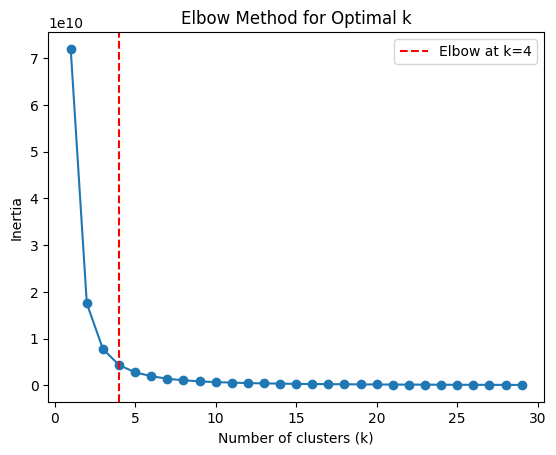

The elbow point is at k = 4


In [158]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Define a range for the number of clusters
k_values = range(1, 30)
inertias = []

# Calculate inertia for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_train)  
    inertias.append(kmeans.inertia_)

# Use KneeLocator to identify the elbow point
knee_locator = KneeLocator(k_values, inertias, curve='convex', direction='decreasing')
elbow_point = knee_locator.elbow

# Plot the inertia values with the identified elbow
plt.plot(k_values, inertias, marker='o')
plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow at k={elbow_point}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.show()

print(f"The elbow point is at k = {elbow_point}")

### 2) hyperparameter tuning use __silhoutte score__
Which is the mean silhouette coefficient over all the instances. The instance’s silhouette coefficient is equal to (b – a) / max(a, b), where a is the mean distance to the other instances in the same cluster (i.e., the mean intra-cluster distance) and b is the mean nearest-cluster distance (i.e., the mean distance to the instances of the next closest cluster, defined as the one that minimizes b, excluding the instance’s own cluster). The silhouette coefficient can vary between –1 and +1. A coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to –1 means that the instance may have been assigned to the wrong cluster.

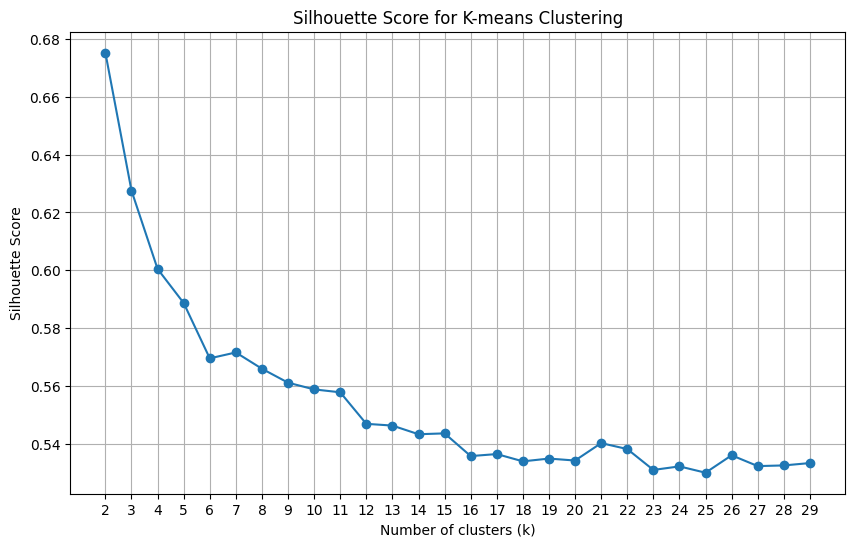

The optimal number of clusters (k) based on silhouette score is: 2


In [159]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define a range for the number of clusters
k_values = range(2, 30)  # Start from 2 since silhouette score needs at least 2 clusters
silhouette_scores = []

# Calculate silhouette score for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(df_train)  # df_combined is your dataset
    score = silhouette_score(df_train, cluster_labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-means Clustering')
plt.xticks(k_values)
plt.grid()
plt.show()

# Identify the optimal k
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters (k) based on silhouette score is: {optimal_k}")



# import pandas as pd
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# def perform_clustering(data, cluster_range=(2, 30)):
#     """
#     Perform KMeans clustering on the given dataset and return the optimal cluster details.

#     Parameters:
#         data (pd.DataFrame): Dataset to cluster.
#         cluster_range (tuple): Range of cluster values to evaluate.

#     Returns:
#         dict: Dictionary containing optimal clusters and related information.
#     """
#     k_values = range(cluster_range[0], cluster_range[1])
#     silhouette_scores = []
    
#     for k in k_values:
#         kmeans = KMeans(n_clusters=k, random_state=42)
#         cluster_labels = kmeans.fit_predict(data)
#         score = silhouette_score(data, cluster_labels)
#         silhouette_scores.append(score)
    
#     optimal_k = k_values[np.argmax(silhouette_scores)]
#     best_kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(data)
    
#     return {
#         "optimal_k": optimal_k,
#         "model": best_kmeans,
#         "labels": best_kmeans.labels_,
#         "silhouette_scores": silhouette_scores
#     }
# # Call the reusable clustering function
# clustering_results = perform_clustering(df_train, cluster_range=(2, 30))

# # Access results
# optimal_k = clustering_results["optimal_k"]
# model = clustering_results["model"]
# labels = clustering_results["labels"]
# silhouette_scores = clustering_results["silhouette_scores"]

# print(f"Optimal number of clusters: {optimal_k}")

# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.plot(range(2, 30), silhouette_scores, marker='o')
# plt.title('Silhouette Scores for Different k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.xticks(k_values)
# plt.grid()
# plt.show()

In [160]:
# save model
import joblib 

kmeans_final = KMeans(n_clusters=optimal_k, random_state=0)
kmeans_final.fit(df_train)  # df_train is your dataset

# Save the trained KMeans model with the optimal k
joblib.dump(kmeans_final, 'kmeans_optimal_basic.pkl')  # Save to file

print("The model with the optimal number of clusters has been saved.")

The model with the optimal number of clusters has been saved.


### <span style="color:blue">Visualize the clustering with K = 2 and K = 4 </span>

### cluster visualization

### a. T-SEN

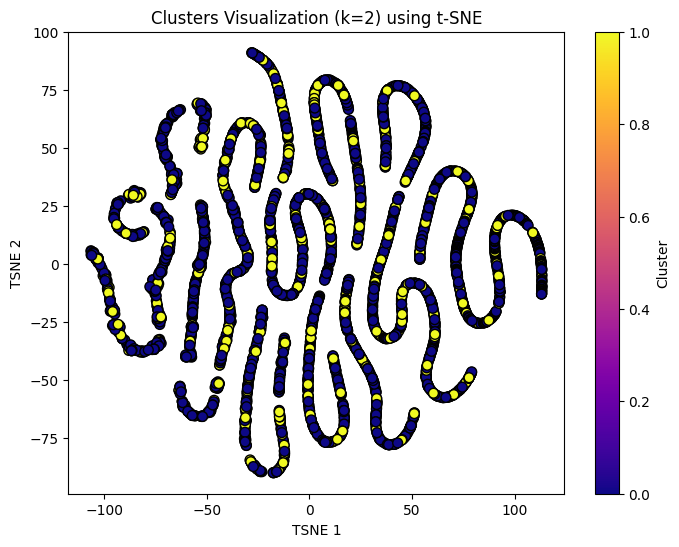

In [161]:
from sklearn.manifold import TSNE

X = df_train
kmeans = KMeans(n_clusters=2, random_state=42)
df_train['cluster'] = kmeans.fit_predict(X)
# Apply t-SNE for better visualization of high-dimensional data
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame for the t-SNE results
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = df_train['cluster']

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['cluster'], cmap='plasma', edgecolor='k', s=50)
plt.title('Clusters Visualization (k=2) using t-SNE')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.colorbar(label='Cluster')
plt.savefig('Kmeans_TSNE.pdf')
plt.show()


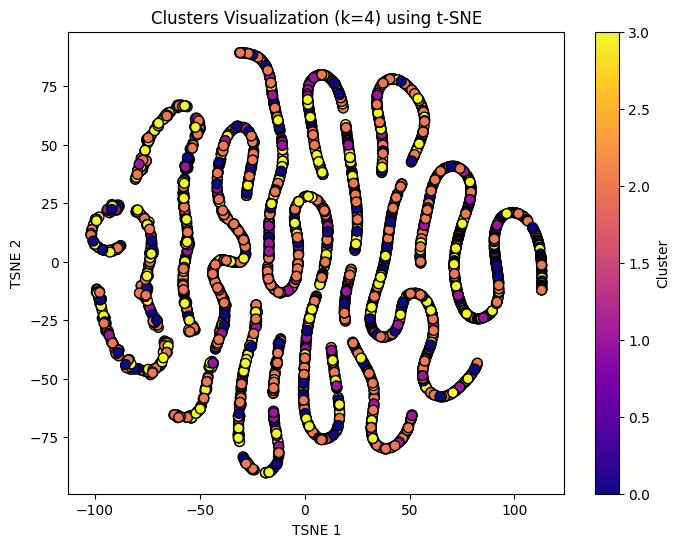

In [162]:
from sklearn.manifold import TSNE

X = df_train
kmeans = KMeans(n_clusters=4, random_state=42)
df_train['cluster'] = kmeans.fit_predict(X)
# Apply t-SNE for better visualization of high-dimensional data
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame for the t-SNE results
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = df_train['cluster']

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['cluster'], cmap='plasma', edgecolor='k', s=50)
plt.title('Clusters Visualization (k=4) using t-SNE')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.colorbar(label='Cluster')
plt.savefig('Kmeans_TSNE.pdf')
plt.show()


### b. PCA 

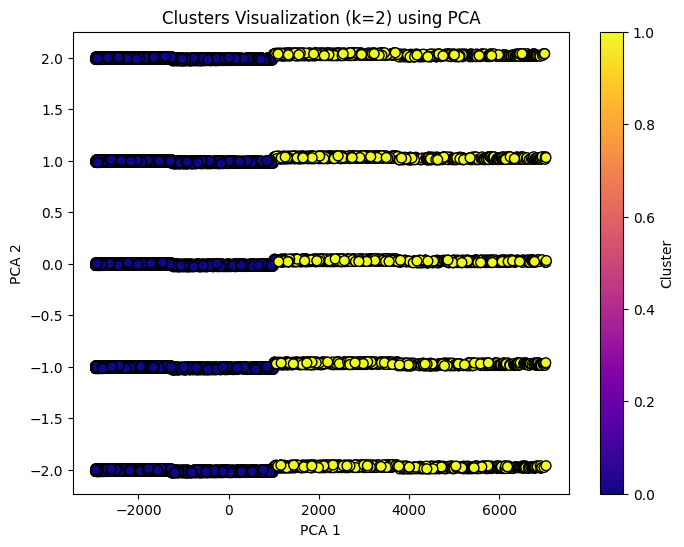

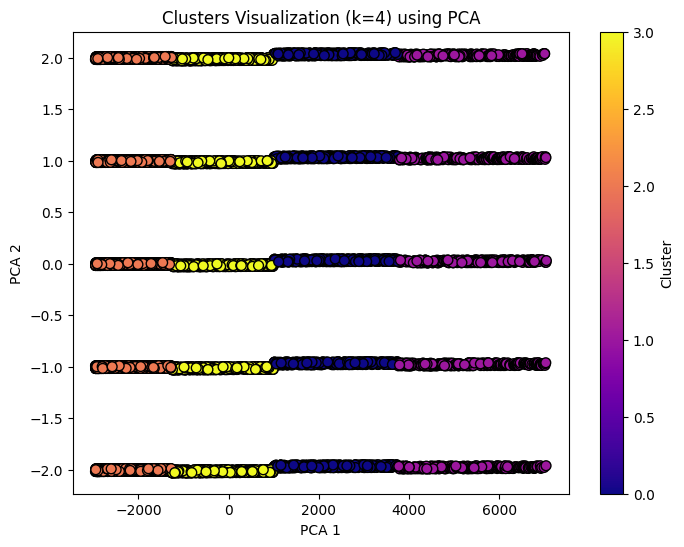

In [163]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_train is already defined
X = df_train

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Function to cluster and plot for a given k
def plot_pca_clusters(X_pca, n_clusters, filename):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)

    # Create a DataFrame for PCA results
    df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
    df_pca['cluster'] = clusters

    # Plotting
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        df_pca['PCA1'], 
        df_pca['PCA2'], 
        c=df_pca['cluster'], 
        cmap='plasma', 
        edgecolor='k', 
        s=50
    )
    plt.title(f'Clusters Visualization (k={n_clusters}) using PCA')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar(scatter, label='Cluster')
    plt.savefig(filename)
    plt.show()

# Plot for k=2
plot_pca_clusters(X_pca, n_clusters=2, filename='Kmeans_PCA_k2.pdf')

# Plot for k=4
plot_pca_clusters(X_pca, n_clusters=4, filename='Kmeans_PCA_k4.pdf')


Since both K=2 and K=4 could provide well-balanced and separated cluster. I will K=2 for my K-means model for the computational cost and overfitting concern.

In [164]:
df_train = df_train.drop('cluster',axis = 1)

## Risk management

### 1. sensitivity to initial centroids: report the score with different initialization
* Risk: The performance of K-Means can be highly sensitive to the initial placement of centroids. Different initializations can lead to different clustering results, especially if the clusters have varying sizes or densities.
* Solution: Use K-Means++ for smarter initialization or run the algorithm multiple times and select the best result.

In [165]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Number of random initializations
n_init = 10
scores = []

for i in range(n_init):
    kmeans = KMeans(n_clusters=3, n_init=1, init='k-means++')
    kmeans.fit(X)  # Replace X with your data
    score = silhouette_score(X, kmeans.labels_)
    scores.append(score)

# Check variation in silhouette scores
print(f"Average silhouette score: {np.mean(scores)}")
print(f"Standard deviation of silhouette scores: {np.std(scores)}")


Average silhouette score: 0.6271305790779909
Standard deviation of silhouette scores: 0.0003525139949824033


#### the standard deviation of silhouette scores is small it means the model is stable

### 2. Sensitive to outlier
* detect outliner use Z score

In [166]:
import numpy as np

# Using Z-score to detect outliers
from scipy.stats import zscore

z_scores = np.abs(zscore(X))  # Replace X with your data
outliers = (z_scores > 3).all(axis=1)  # Points with Z-score > 3 are outliers

# Print outliers
print("Outlier rows:", np.where(outliers)[0])


Outlier rows: []


#### no outlier detected

### 3. Label stability
* Adjusted Rand Index (ARI), which measures the similarity between two clustering result

In [167]:
from sklearn.metrics import adjusted_rand_score

# Store the cluster labels from each run
labels_list = []
n_runs = 10
# Run K-Means multiple times and store the labels
for i in range(n_runs):
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=i)
    labels = kmeans.fit_predict(X)
    labels_list.append(labels)

# Compare the cluster labels between different runs
ari_scores = []

for i in range(n_runs):
    for j in range(i + 1, n_runs):
        ari_score = adjusted_rand_score(labels_list[i], labels_list[j])
        ari_scores.append(ari_score)

print(f"Adjusted Rand Index (ARI) scores: {ari_scores}")


Adjusted Rand Index (ARI) scores: [0.684051707874362, 0.7680306451823804, 0.6429722017445082, 0.637340601797105, 0.72582458871916, 0.6339245787230904, 0.7493562487432281, 0.7328973622433934, 0.7188247722209472, 0.7395743437806039, 0.6974284963540579, 0.6863667201024316, 0.7559009761360236, 0.779121308852915, 0.7384412654280301, 0.7434079818512319, 0.7765977397751758, 0.750795051293391, 0.5930506831644602, 0.6492932374370582, 0.7397796150365331, 0.654725744989074, 0.6343479819041482, 0.6705711933158309, 0.602732946810526, 0.6880097068237891, 0.7838072306669503, 0.6505003879778575, 0.6355422000175253, 0.6610835320666069, 0.7619468303255206, 0.6358715995425074, 0.6660070773294556, 0.7049824517304429, 0.7699017371318612, 0.7412779639897062, 0.7754614413962414, 0.8264520109180492, 0.9213830745546453, 0.7612553422630666, 0.7620586485414027, 0.7346979935459457, 0.8631465323184279, 0.7829509773220955, 0.8198572211966331]


### 4. Choice of K (see hyperparameter tuning)

## Trustworthiness

### 1. Compare different clustering method
* compare the runtime with K-means and mini batch K-means

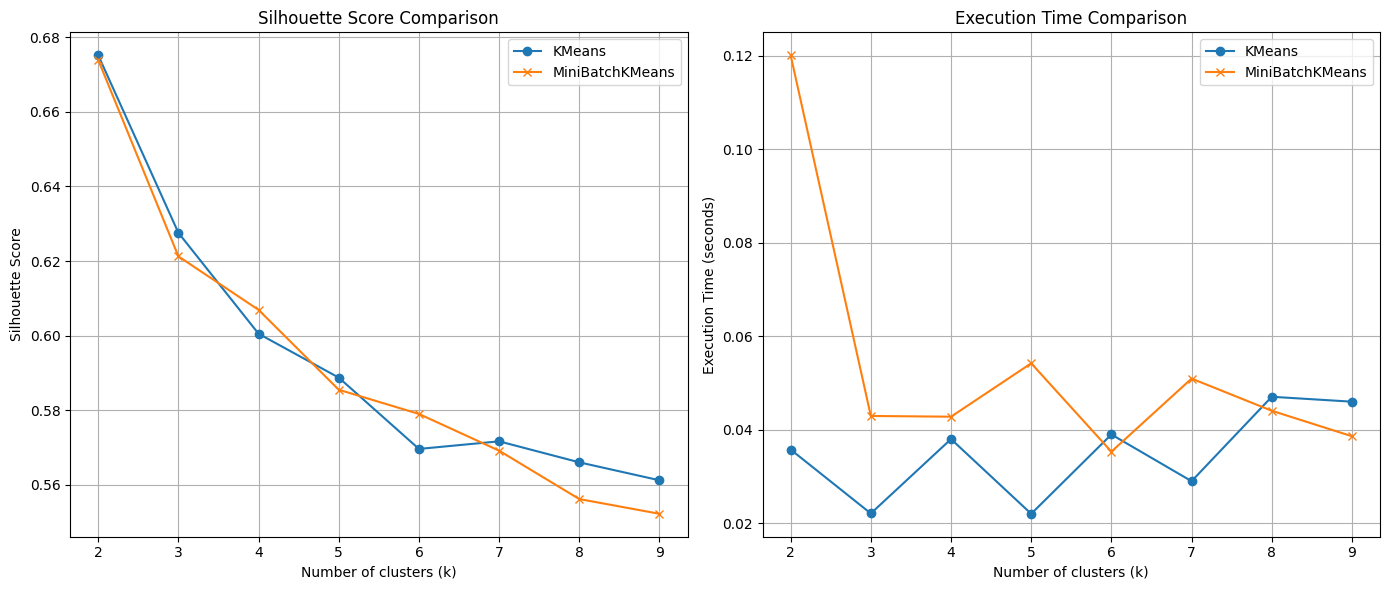

Optimal number of clusters for KMeans: 2
Optimal number of clusters for MiniBatchKMeans: 2
KMeans execution time for optimal k: 0.035761117935180664 seconds
MiniBatchKMeans execution time for optimal k: 0.12012028694152832 seconds


In [168]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
import time  # To measure execution time

# Define a range for the number of clusters
k_values = range(2, 10)  # Start from 2 since silhouette score needs at least 2 clusters
kmeans_times = []
mini_batch_kmeans_times = []
silhouette_scores_kmeans = []
silhouette_scores_mini_batch_kmeans = []

# Loop to compare execution time and silhouette scores
for k in k_values:
    # Standard KMeans
    start_time = time.time()
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels_kmeans = kmeans.fit_predict(df_train)  # df_train is your dataset
    kmeans_time = time.time() - start_time
    kmeans_times.append(kmeans_time)
    
    score_kmeans = silhouette_score(df_train, cluster_labels_kmeans)
    silhouette_scores_kmeans.append(score_kmeans)
    
    # MiniBatchKMeans
    start_time = time.time()
    mini_batch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
    cluster_labels_mini_batch_kmeans = mini_batch_kmeans.fit_predict(df_train)
    mini_batch_kmeans_time = time.time() - start_time
    mini_batch_kmeans_times.append(mini_batch_kmeans_time)
    
    score_mini_batch_kmeans = silhouette_score(df_train, cluster_labels_mini_batch_kmeans)
    silhouette_scores_mini_batch_kmeans.append(score_mini_batch_kmeans)

# Plotting the silhouette scores
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores_kmeans, label='KMeans', marker='o')
plt.plot(k_values, silhouette_scores_mini_batch_kmeans, label='MiniBatchKMeans', marker='x')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Comparison')
plt.legend()
plt.grid()

# Plotting the execution times
plt.subplot(1, 2, 2)
plt.plot(k_values, kmeans_times, label='KMeans', marker='o')
plt.plot(k_values, mini_batch_kmeans_times, label='MiniBatchKMeans', marker='x')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Identify the optimal k based on silhouette score for both KMeans and MiniBatchKMeans
optimal_k_kmeans = k_values[np.argmax(silhouette_scores_kmeans)]
optimal_k_mini_batch_kmeans = k_values[np.argmax(silhouette_scores_mini_batch_kmeans)]

print(f"Optimal number of clusters for KMeans: {optimal_k_kmeans}")
print(f"Optimal number of clusters for MiniBatchKMeans: {optimal_k_mini_batch_kmeans}")

# Print execution times for the best k values
print(f"KMeans execution time for optimal k: {kmeans_times[np.argmax(silhouette_scores_kmeans)]} seconds")
print(f"MiniBatchKMeans execution time for optimal k: {mini_batch_kmeans_times[np.argmax(silhouette_scores_mini_batch_kmeans)]} seconds")


#### The execution time of K-means is faster than MiniBatch KMeans. The optimial number of cluster is 3 for both

### 2. Bias detecting
* check the number of members in each cluster

In [169]:
import numpy as np
from sklearn.cluster import KMeans

# Assuming X is the dataset
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Check the size of each cluster
unique, counts = np.unique(kmeans.labels_, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

print(f"Cluster sizes: {cluster_sizes}")


Cluster sizes: {np.int32(0): np.int64(2778), np.int32(1): np.int64(1762), np.int32(2): np.int64(5460)}


#### No significant imbalance of cluster

## Human Computer Interaction(please check app.py use streamlit)
